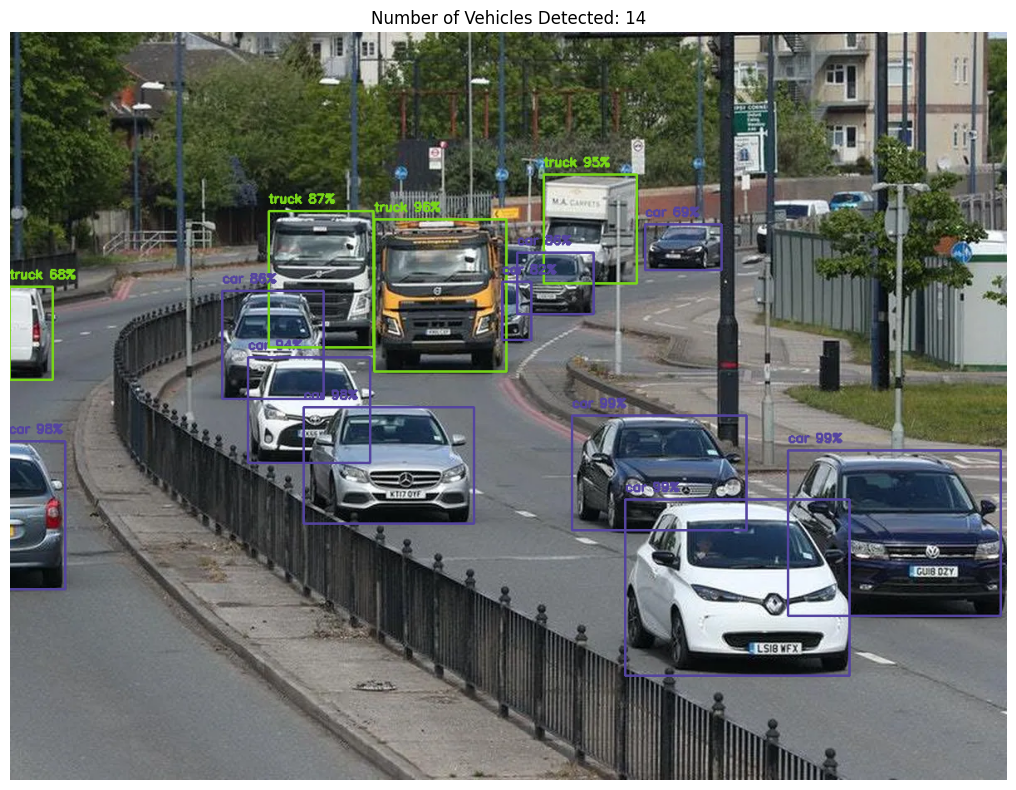

Number of vehicles (cars, trucks, buses) in this image: 14


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Read the image
image_path = "/Users/allullaswarantej/Downloads/cars.jpeg"
image = cv2.imread(image_path)

# Check if image was successfully loaded
if image is None:
    print(f"Error: Could not read the image from {image_path}")
    exit()

# Convert BGR to RGB for display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load pre-trained YOLO model
# First, ensure these files exist in your working directory (or specify full paths)
weights_path = os.path.expanduser("~/.cvlib/object_detection/yolo/yolov4.weights")
config_path = os.path.expanduser("~/.cvlib/object_detection/yolo/yolov4.cfg")

# Create directory for weights if it doesn't exist
os.makedirs(os.path.dirname(weights_path), exist_ok=True)

# Check if weights file exists, if not download it
if not os.path.exists(weights_path):
    print("Downloading YOLOv4 weights... (this may take a while)")
    # Simplified download code - you might want to use a progress bar in a real application
    import urllib.request
    urllib.request.urlretrieve("https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights", weights_path)

# Check if config file exists, if not download it
if not os.path.exists(config_path):
    print("Downloading YOLOv4 config...")
    import urllib.request
    urllib.request.urlretrieve("https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4.cfg", config_path)

# Load the YOLO network
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)

# Configure backend
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)  # Use CPU, change to DNN_TARGET_CUDA for GPU

# Load classes
classes_path = os.path.expanduser("~/.cvlib/object_detection/yolo/coco.names")
if not os.path.exists(classes_path):
    print("Downloading class names...")
    os.makedirs(os.path.dirname(classes_path), exist_ok=True)
    import urllib.request
    urllib.request.urlretrieve("https://raw.githubusercontent.com/AlexeyAB/darknet/master/data/coco.names", classes_path)

with open(classes_path, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# Get output layer names
layer_names = net.getLayerNames()
output_layers = [layer_names[i-1] for i in net.getUnconnectedOutLayers().flatten()]

# Prepare the image
height, width, channels = image.shape
blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

# Set input to the network
net.setInput(blob)

# Run forward pass
outputs = net.forward(output_layers)

# Process detections
boxes = []
confidences = []
class_ids = []

for output in outputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:  # Confidence threshold
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Apply non-maximum suppression
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# Count cars
car_count = 0
colors = np.random.uniform(0, 255, size=(len(classes), 3))

# Create a copy of the image to draw on
output_image = image_rgb.copy()

if len(indices) > 0:
    for i in indices.flatten():
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        if label == 'car' or label == 'truck' or label == 'bus':
            car_count += 1
            confidence = confidences[i]
            color = colors[class_ids[i]]
            cv2.rectangle(output_image, (x, y), (x + w, y + h), color, 2)
            cv2.putText(output_image, f"{label} {int(confidence*100)}%", (x, y - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Display the image with bounding boxes
plt.figure(figsize=(12, 8))
plt.imshow(output_image)
plt.title(f'Number of Vehicles Detected: {car_count}')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Number of vehicles (cars, trucks, buses) in this image: {car_count}")